In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import meerkat as mk
import numpy as np
import torch
import clip
from PIL import Image
import ray
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

df = mk.get("imagenette", version="160px")

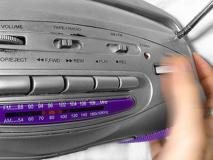

In [5]:
df["img"][0]()

In [6]:
out = df.defer(lambda img: np.array(img.resize((100, 100)))).map(lambda img: img.mean(), use_ray=True)

# Working on the ray map

In [7]:
data = out
data

,(DeferredColumn)
0,DeferredCell
1,DeferredCell
2,DeferredCell
3,DeferredCell
4,DeferredCell
...,...
13389,DeferredCell
13390,DeferredCell
13391,DeferredCell
13392,DeferredCell


In [25]:
# Step 1: Walk through the DeferredColumns and build a list of functions
curr = data
fns = []
while isinstance(curr, mk.DeferredColumn): # and not isinstance(curr, mk.ImageColumn):
    print(curr)
    
    if isinstance(curr, mk.ImageColumn) and False:
        # Method 0 is to continue with appending curr.data.fn
        
        # Method 1 (wrap the fn with a lambda function to extract x["0"])
        fns.append(lambda x: curr.data.fn(x["0"]))
        curr = curr.data.args[0]
        break
        
        # Method 2
        # TODO: We will need to wrap in a lambda function that converts to PIL and
        #       accesses the "image" col
        paths = list(curr.data.fn.base_dir + curr.data.args[0])
        ds = ray.data.read_images(paths)
        break
    
    fns.append(curr.data.fn)
    
    # For linear pipelines, there will be one elem in args or one key in kwargs
    if curr.data.args:
        if len(curr.data.args) > 1:
            raise ValueError("Cannot handle multiple args")
        curr = curr.data.args[0] # Get first element in args
    elif curr.data.kwargs:
        if len(curr.data.kwargs) > 1:
            raise ValueError("Cannot handle multiple args")
        curr = curr.data.kwargs[next(iter(curr.data.kwargs))] # Get first value in args
    else:
        print("ERROR: no args or kwargs")

DeferredColumn(DeferredOp(ar...rn_index=None))
DeferredColumn(DeferredOp(ar...rn_index=None))
ImageColumn(DeferredOp(ar...rn_index=None))


In [26]:
# Step 2: Create the ray dataset from the base column
print("Base type is ", type(curr))
if isinstance(curr, mk.ScalarColumn):
    ds = ray.data.from_pandas(pd.DataFrame({"0": curr})).repartition(100)
    fns.append(lambda x: x["0"])
else:
    print("ERROR: unclear base type")
print("\n".join([str(fn) for fn in fns]))
# ds.show()

Base type is  <class 'meerkat.columns.scalar.pandas.PandasScalarColumn'>


Repartition: 100%|██████████| 100/100 [00:01<00:00, 91.06it/s]

<function <lambda> at 0x7f8edf5d9820>
<function <lambda> at 0x7f8edd08ac10>


In [28]:
# curr[0]
# res = {"0": curr[0]}
res = curr[0]
for i, fn in enumerate(reversed(fns)):
    print(f"DEAN {i}")
    res = fn(res)
    print(res)

DEAN 0
<PIL.Image.Image image mode=RGB size=213x160 at 0x7F8E9EEA9880>
DEAN 1
[[[174 174 174]
  [173 173 173]
  [173 173 173]
  ...
  [252 252 252]
  [239 239 239]
  [190 190 190]]

 [[177 177 177]
  [175 175 175]
  [173 173 173]
  ...
  [246 246 246]
  [203 203 203]
  [181 181 181]]

 [[175 175 175]
  [172 172 172]
  [169 169 169]
  ...
  [220 220 220]
  [173 173 173]
  [182 182 182]]

 ...

 [[ 95  95  95]
  [ 95  95  95]
  [ 94  94  94]
  ...
  [162 127  96]
  [160 123  92]
  [149 112  84]]

 [[131 131 131]
  [130 130 130]
  [128 128 128]
  ...
  [160 125  94]
  [160 122  90]
  [146 111  82]]

 [[110 110 110]
  [108 108 108]
  [105 105 105]
  ...
  [157 122  91]
  [155 118  85]
  [141 106  77]]]
DEAN 2
135.48786666666666


In [15]:
# Step 3: Build the pipeline
pipe: ray.data.DatasetPipeline = ds.window(blocks_per_window=10)
for fn in fns:
    pipe = pipe.map(fn)

2023-01-18 18:10:24,191	INFO dataset.py:3693 -- Created DatasetPipeline with 10 windows: 0.12MiB min, 0.12MiB max, 0.12MiB mean
2023-01-18 18:10:24,197	INFO dataset.py:3703 -- Blocks per window: 10 min, 10 max, 10 mean
2023-01-18 18:10:24,213	WARNING dataset.py:3715 -- ⚠️  This pipeline's parallelism is limited by its blocks per window to ~10 concurrent tasks per window. To maximize performance, increase the blocks per window to at least 12. This may require increasing the base dataset's parallelism and/or adjusting the windowing parameters.
2023-01-18 18:10:24,215	INFO dataset.py:3742 -- ✔️  This pipeline's windows likely fit in object store memory without spilling.


In [ ]:
# Step 4: Iterate through the blocks? (there are 10 iterations)
result = np.array([])
partitions = iter(pipe.rewindow(blocks_per_window=100).iter_datasets()).__next__().to_numpy_refs()
for partition in partitions: # 100 partitions
    result = np.append(result, ray.get(partition))

Stage 0:   0%|          | 0/1 [00:00<?, ?it/s]](_map_block_split pid=5646) 2023-01-18 18:10:30,501	INFO worker.py:763 -- Task failed with retryable exception: TaskID(558e8c7c005a62e5ffffffffffffffffffffffff01000000).
(_map_block_split pid=5646) Traceback (most recent call last):
(_map_block_split pid=5646)   File "python/ray/_raylet.pyx", line 619, in ray._raylet.execute_dynamic_generator_and_store_task_outputs
(_map_block_split pid=5646)   File "python/ray/_raylet.pyx", line 2421, in ray._raylet.CoreWorker.store_task_outputs
(_map_block_split pid=5646)   File "/Users/deanstratakos/opt/anaconda3/envs/meerkat/lib/python3.9/site-packages/ray/data/_internal/compute.py", line 459, in _map_block_split
(_map_block_split pid=5646)     for new_block in block_fn(blocks, *fn_args, **fn_kwargs):
(_map_block_split pid=5646)   File "/Users/deanstratakos/opt/anaconda3/envs/meerkat/lib/python3.9/site-packages/ray/data/_internal/plan.py", line 951, in wrapper
(_map_block_split pid=5646)     for block 

RayTaskError(AttributeError): [36mray::_map_block_split()[39m (pid=5635, ip=127.0.0.1)
  File "/Users/deanstratakos/opt/anaconda3/envs/meerkat/lib/python3.9/site-packages/ray/data/_internal/compute.py", line 459, in _map_block_split
    for new_block in block_fn(blocks, *fn_args, **fn_kwargs):
  File "/Users/deanstratakos/opt/anaconda3/envs/meerkat/lib/python3.9/site-packages/ray/data/_internal/plan.py", line 951, in wrapper
    for block in blocks:
  File "/Users/deanstratakos/opt/anaconda3/envs/meerkat/lib/python3.9/site-packages/ray/data/_internal/plan.py", line 951, in wrapper
    for block in blocks:
  File "/Users/deanstratakos/opt/anaconda3/envs/meerkat/lib/python3.9/site-packages/ray/data/_internal/plan.py", line 951, in wrapper
    for block in blocks:
  File "/Users/deanstratakos/opt/anaconda3/envs/meerkat/lib/python3.9/site-packages/ray/data/_internal/plan.py", line 952, in wrapper
    yield from fn(block, *args, **kwargs)
  File "/Users/deanstratakos/opt/anaconda3/envs/meerkat/lib/python3.9/site-packages/ray/data/dataset.py", line 305, in transform
    output_buffer.add(fn(row))
  File "/var/folders/r0/8smwyb4d2bv_rpcdh0dwd9w00000gn/T/ipykernel_5541/1874602208.py", line 1, in <lambda>
AttributeError: 'PandasRow' object has no attribute 'mean'

(raylet) [2023-01-18 18:10:33,630 E 5632 2691848] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-01-18_18-04-37_519262_5541 is over 95% full, available space: 18318684160; capacity: 499963174912. Object creation will fail if spilling is required.
(raylet) [2023-01-18 18:10:43,685 E 5632 2691848] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-01-18_18-04-37_519262_5541 is over 95% full, available space: 19391275008; capacity: 499963174912. Object creation will fail if spilling is required.
(raylet) [2023-01-18 18:10:53,741 E 5632 2691848] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-01-18_18-04-37_519262_5541 is over 95% full, available space: 19391266816; capacity: 499963174912. Object creation will fail if spilling is required.
(raylet) [2023-01-18 18:11:03,802 E 5632 2691848] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-01-18_18-04-37_519262_5541 is over 95% full, available space: 19391209472; capacity: 499963174912. Object creation